In [1]:
from foundry.util.runtime import setup
setup()

from image_diffusion.main import logger
logger.setLevel('INFO')

import foundry.random
import foundry.core.tree as tree
import foundry.numpy as npx
import foundry.train

from foundry.core.dataclasses import dataclass, replace

import foundry.core as F
import flax.linen as nn
import flax.linen.activation as activations

import rich
import jax
import optax
import foundry.train.console
import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt
from typing import Sequence

# Use only the CPU for visualizations
jax.config.update("jax_platform_name", "cpu")

print("Devices:", jax.devices())

Devices: [CpuDevice(id=0)]


In [2]:
color_map = {
    0: "#E52B50",
    1: "#9F2B68",
    2: "#3B7A57",
    3: "#3DDC84",
    4: "#FFBF00",
    5: "#915C83",
    6: "#008000",
    7: "#7FFFD4",
    8: "#E9D66B",
    9: "#007FFF",
}
def embed_scatter(zs, labels, **kwargs):
    colors = [color_map[label.item()] for label in labels]
    plt.scatter(zs[:, 0], zs[:, 1], c=colors, **kwargs)

def map(f, batch_size=None):
    return lambda *x: jax.lax.map(lambda x: f(*x), x, batch_size=batch_size)

def smoothing_eval(xs, ys, vals, radius=1/32):
    x_min, x_max = npx.min(xs), npx.max(xs)
    y_min, y_max = npx.min(ys), npx.max(ys)
    x_bw, y_bw = (x_max - x_min)*radius, (y_max - y_min)*radius

    def eval(x, y):
        dists_sqr = (xs - x)**2/(x_bw**2) + (ys - y)**2/(y_bw**2)
        log_kernel = -dists_sqr
        log_kernel = log_kernel - jax.scipy.special.logsumexp(log_kernel)
        return npx.exp(jax.scipy.special.logsumexp(log_kernel, b=vals))
    return eval

def smoothed_colormesh(eval, *, 
        x_min, x_max, y_min, y_max,
        val_clip=None, **kwargs):
    xs_high = npx.linspace(x_min, x_max, 256)
    ys_high = npx.linspace(y_min, y_max, 256)
    XS_high, YS_high = npx.meshgrid(xs_high, ys_high)
    vals_high = map(map(eval, batch_size=4), batch_size=4)(XS_high, YS_high)
    if val_clip is not None:
        vals_high = vals_high.clip(-val_clip, val_clip)
    # plt.scatter(xs, ys, c=vals, **kwargs)
    plt.pcolormesh(xs_high, ys_high, vals_high, **kwargs)

In [16]:
import foundry.util.serialize
import wandb
api = wandb.Api()
artifact = api.artifact("dpfrommer-projects/image-diffusion-eval/evaluation:v19")
entries = list(artifact.files())
data_url = entries[-1]._attrs["directUrl"]
eval_data = foundry.util.serialize.load(data_url)
checkpoint_url = eval_data.checkpoint_uri
checkpoint = foundry.util.serialize.load(checkpoint_url)

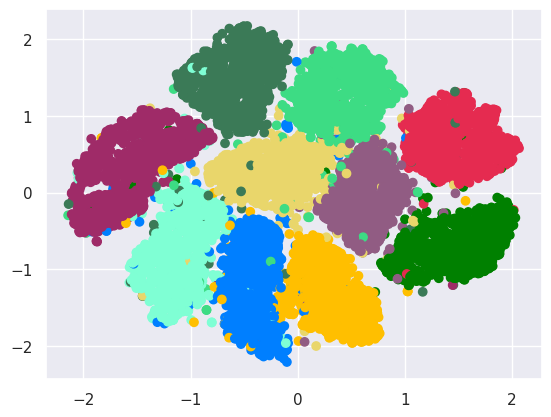

In [17]:
import jax
model = checkpoint.config.create()
schedule = checkpoint.schedule
vars = checkpoint.vars
normalizer, train_data, test_data = checkpoint.create_data()
train_data = jax.vmap(normalizer.normalize)(train_data.as_pytree())
test_data = jax.vmap(normalizer.normalize)(test_data.as_pytree())

latents = test_data.cond
embed_scatter(latents, test_data.label)

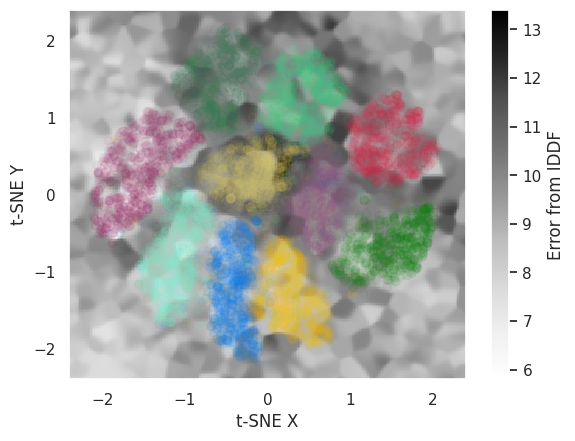

In [20]:
smoothed_colormesh(
    smoothing_eval(
        eval_data.cond[:,0], 
        eval_data.cond[:,1], 
        npx.mean(eval_data.nw_error, -1),
        radius=1/64
    ),
    x_min=-2.4, x_max=2.4,
    y_min=-2.4, y_max=2.4,
    cmap="Greys"
)
plt.ylim(-2.4, 2.4)
plt.xlim(-2.4, 2.4)
plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
cbar = plt.colorbar()
cbar.set_label("Error from IDDF")
embed_scatter(latents, test_data.label, alpha=0.04)

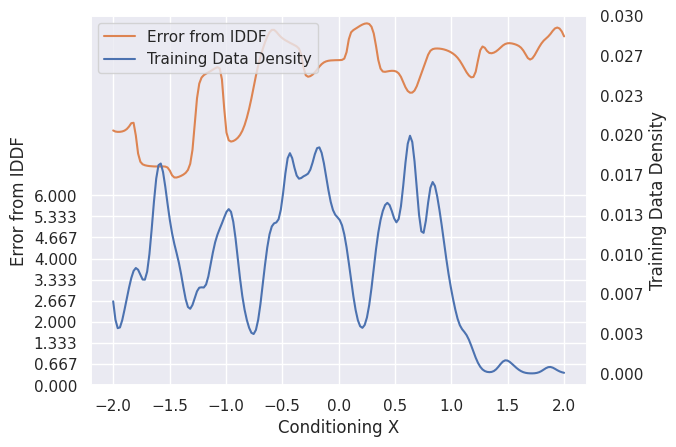

In [21]:
def latent_density(x):
    sigma = 0.05
    log_density = -npx.sum(npx.square(latents - x), axis=-1)/(2*sigma**2)
    N = log_density.shape[0]
    log_density = jax.scipy.special.logsumexp(log_density)
    log_norm = 1/2*npx.log(2*npx.pi) + npx.log(sigma) + npx.log(N)
    return npx.exp(log_density - log_norm)

t = npx.linspace(-2, 2, 200)
zs = npx.array([1, 0])[None,:]*t[:,None]
density = F.vmap(latent_density)(zs)
nw_err = F.vmap(smoothing_eval(
    eval_data.cond[:,0], eval_data.cond[:,1], 
    npx.mean(eval_data.nw_error, -1),
    radius=1/64,
))(zs[:,0], zs[:,1])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax1 = plt.subplots()
ax1.set_xlabel("Conditioning X")

h1, = ax1.plot(t, nw_err, color=colors[1], label="Error from IDDF")
ax1.set_ylabel("Error from IDDF")

ax2 = ax1.twinx()

h2, = ax2.plot(t, density, color=colors[0], label="Training Data Density")
ax2.set_ylabel("Training Data Density")

ax2.grid(False)


# ax1.set_yticks(npx.linspace(0, 6, 10))
ax2.set_yticks(npx.linspace(0, 0.03, 10))
ax1.tick_params(axis="y", left=False, right=False)
ax2.tick_params(axis="y", left=False, right=False)
ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))

ax2.legend(handles=[h1,h2], loc="upper left")

fig.show()

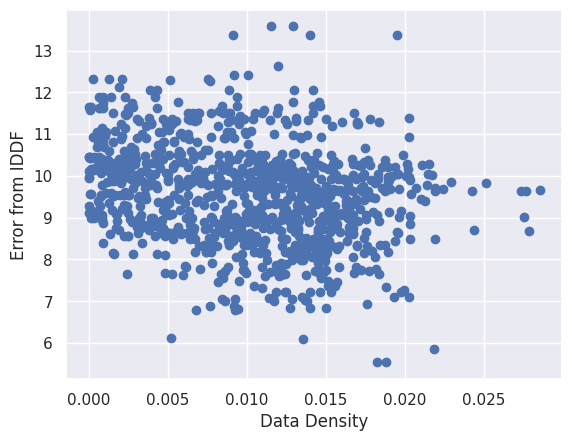

In [22]:
Xs, Ys = npx.meshgrid(npx.linspace(-2.4, 2.4, 50), npx.linspace(-2.4, 2.4, 50))
Xs, Ys = Xs.reshape(-1), Ys.reshape(-1)
mask = Xs**2 + Ys**2 <= 1.8**2
Xs, Ys = Xs[mask], Ys[mask]
density = F.vmap(latent_density)(npx.stack((Xs, Ys), -1))
error = F.vmap(smoothing_eval(
    eval_data.cond[:,0], 
    eval_data.cond[:,1], 
    eval_data.nw_error.mean(-1),
    radius=1/256
    ))(Xs, Ys)

plt.ylabel("Error from IDDF")
plt.xlabel("Data Density")
plt.scatter(density, error)

In [8]:
import foundry.train
import foundry.train.console
import flax.linen as nn
from foundry.train import LossOutput
from foundry.data import PyTreeData

USE_SOFTMAX = False
USED_KEYPOINTS = 32
USE_T = True
assert USED_KEYPOINTS <= keypoints.shape[0]


keypoint_model = KeypointModel()
keypoint_vars = keypoint_model.init(foundry.random.key(42),
    npx.zeros((2,)), npx.zeros((), dtype=npx.int32)
)
iterations = 10_000
optimizer = optax.adamw(optax.cosine_decay_schedule(4e-3, iterations))
opt_state = optimizer.init(keypoint_vars["params"])

@foundry.train.batch_loss
def loss_fn(keypoint_vars, rng_key, sample):
    alphas = keypoint_model.apply(keypoint_vars, sample.cond, sample.t)
    interpolated = alphas[:, None, None, None] * sample.out_keypoints[:USED_KEYPOINTS]
    interpolated = npx.sum(interpolated, axis=0)
    err = npx.mean(npx.square(interpolated - sample.out_model))
    return LossOutput(
        loss=err,
        metrics={"error": npx.sqrt(err)}
    )

with foundry.train.loop(
    PyTreeData(eval_samples).stream().shuffle(foundry.random.key(42)).batch(128),
    iterations=iterations,
    rng_key=foundry.random.key(42)
) as loop:
    for epoch in loop.epochs():
        for step in epoch.steps():
            opt_state, keypoint_vars, metrics = foundry.train.step(
                loss_fn, optimizer, opt_state=opt_state,
                vars=keypoint_vars, rng_key=step.rng_key,
                batch=step.batch
            )
            if step.iteration % 500 == 0:
                foundry.train.console.log(
                    step.iteration, metrics
                )

NameError: name 'keypoints' is not defined

Average error 0.06592249


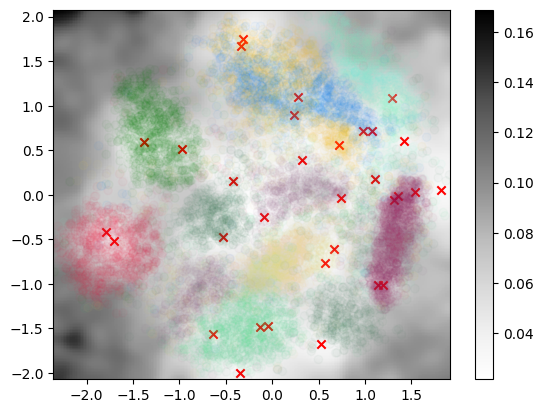

In [11]:
def eval(sample):
    alphas = keypoint_model.apply(keypoint_vars, sample.cond, sample.t)
    interpolated = alphas[:, None, None, None] * sample.out_keypoints[:USED_KEYPOINTS]
    interpolated = npx.sum(interpolated, axis=0)
    err = npx.sqrt(npx.mean(npx.square(interpolated - sample.out_model)))
    return err

keypoint_errs = map(eval, batch_size=256)(eval_samples)
print("Average error", npx.mean(keypoint_errs))

#plt.xlim(-0.15, 0)
#plt.ylim(-0.3,-0.2)
smoothed_colormesh(eval_samples.cond[:,0], eval_samples.cond[:,1], keypoint_errs, eval_samples.t,
                   t_min=0, t_max=32, cmap="Grays")
#plt.scatter(eval_samples.cond[:,0], eval_samples.cond[:,1], c=keypoint_errs, cmap="viridis")
plt.colorbar()
plt.scatter(keypoints[:USED_KEYPOINTS,0], keypoints[:USED_KEYPOINTS,1], c="red", marker="x")
embed_scatter(latents, test_data.label, alpha=0.03)

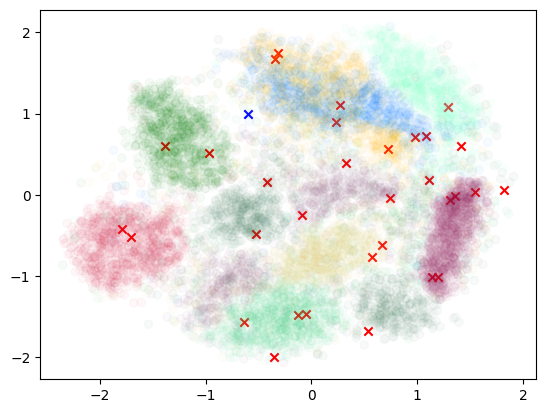

In [12]:
sampling_cond = npx.array([-0.6, 1.0])
plt.scatter(keypoints[:USED_KEYPOINTS,0], keypoints[:USED_KEYPOINTS,1], c="red", marker="x")
plt.scatter(sampling_cond[None,0], sampling_cond[None,1], c="blue", marker="x")
embed_scatter(latents, test_data.label, alpha=0.03)

In [22]:
import functools
import foundry.graphics
from IPython.display import display

from foundry.train import Image

@functools.partial(jax.jit, static_argnums=(0, 3,))
def sample_trajs(denoiser, cond, rng_key, N):
    def sample(rng_key):
        sample, traj = schedule.sample(rng_key, denoiser, npx.zeros(test_data.data[0].shape), trajectory=True)
        outputs = jax.lax.map(lambda s: denoiser(None, s[0], s[1]), (traj, npx.arange(1, 1 + traj.shape[0])))
        return sample, traj, outputs
    samples, trajs, outputs = jax.lax.map(sample, foundry.random.split(rng_key, N), batch_size=8)
    samples = (128*(samples+1)).astype(npx.uint8)
    return Image(foundry.graphics.image_grid(samples)), trajs, outputs

@functools.partial(jax.jit, static_argnums=(2,))
def nn_sample(cond, rng_key, N):
    def denoiser(rng_key, x, t):
        return model.apply(vars, x, t - 1, cond=cond)
    return sample_trajs(denoiser, cond, rng_key, N)

@functools.partial(jax.jit, static_argnums=(2,))
def linear_sample(cond, rng_key, N):
    def denoiser(rng_key, x, t):
        alphas = keypoint_model.apply(keypoint_vars, cond, t)
        out_keypoints = F.vmap(lambda k: model.apply(vars, x, t-1, cond=k))(keypoints[:USED_KEYPOINTS])
        interpolated = alphas[:, None, None, None] * out_keypoints
        interpolated = npx.sum(interpolated, axis=0)
        return interpolated
    return sample_trajs(denoiser, cond, rng_key, N)

nn_grid, nn_trajs, nn_outputs = nn_sample(sampling_cond, jax.random.key(42), 16)
lin_grid, lin_trajs, lin_outputs = linear_sample(sampling_cond, jax.random.key(42), 16)
display(nn_grid)
display(lin_grid)


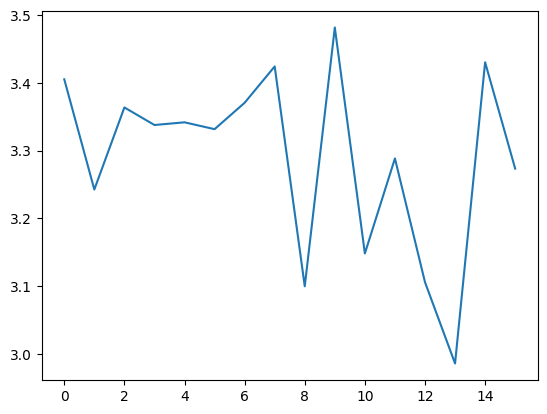

In [29]:
plt.plot(
    npx.arange(nn_outputs.shape[0]), 
    npx.linalg.norm(nn_outputs.reshape(16, -1) - lin_outputs.reshape(16, -1), axis=(-1))/16
)
plt.show()